<a href="https://colab.research.google.com/github/RainaVardhan/CS4774/blob/main/Copy_of_ailaw_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS4501/LAW7127 Fall 2025: Project 1**

# Project 1: Fairness in Student Loans

The goal of this assignment is to explore ways to audit a model for fairness, to get some experience and understanding of how models are trained, and to explore techniques for training a model that makes predictions that align with a fairness goal.

**Copying this notebook:** To get starting, you'll need to make your own copy of this notebook so you can make edits in it. One team member should make a copy (select "File | Save a Copy in Drive" from the menu at the top left). Then, share that copy with all of your teammates (as Editor for the copy). After this, everyone on the team should be able to open the shared notebook and edit it collaboratively.

# Motivating Scenario: Earnest LLC Settlement



On 10 July 2025, the Massachusetts Attorney General announced a settlement with a company, [Earnest Operations LLC](https://www.earnest.com/), that makes student loans for its use of AI models in ways that were considered to violate fair lending laws:

- Massachusetts' Attorney General Press Release: [_AG Campbell Announces $2.5 Million Settlement With Student Loan Lender For Unlawful Practices Through AI Use, Other Consumer Protection Violations_](https://uvalawai.github.io/readings/ag-announcement.pdf), 10 July 2025. (Original link: https://www.mass.gov/news/ag-campbell-announces-25-million-settlement-with-student-loan-lender-for-unlawful-practices-through-ai-use-other-consumer-protection-violations)
- [Settlement (PDF)](https://uvalawai.github.io/readings/earnest-ago-settlement.pdf) (Original link: [https://www.mass.gov/doc/earnest-aod/download](https://www.mass.gov/doc/earnest-aod/download))
- [AG's Advisory (PDF)](https://uvalawai.github.io/readings/ag-advisory.pdf) (Original link: https://www.mass.gov/news/ag-campbell-issues-advisory-providing-guidance-on-how-state-consumer-protection-and-other-laws-apply-to-artificial-intelligence)

In [29]:
# Execute this cell if you want colab to autosave your work (normally only saves when you select File | Save)
%autosave 60

Autosaving every 60 seconds


## Overview and Objectives

For the first part of this assignment, you will get familiar with running and writing Python code in a Colab notebook and performing some statistical tests on loan underwriting decisions in provided data and consider the fairness and legal implications of your analyses.

In the second part, you will get some experience training models on data, assess properties of trained modesl, and aim to develop a training process and resulting model that satisfies fairness and legal requirements.

In Project 2 (assigned after next week), we will explore explainability and interpretability of these models.

## Getting Started

First, we need to import some libraries into our environment. These should already be setup if you are using Google Colab. (If you are running this notebook locally, you may need to install them.)

The two libraries we load below are [NumPy](https://numpy.org/), a library that makes it easy to manipulate large multi-dimensional arrays of numbers, and [Pandas](https://pandas.pydata.org/), a library for data analysis. By using these libraries, we can get a lot done with just a few lines of code.

The next cell in the notebook is code that imports the two libraries. You can run this by pressing the play (triangle pointing to the right) button or typing "shift-enter". When you run a code cell in the notebook, if it executes without error you should see a green check and the time it took to execute, followed by the output it produced in the next cell.

In [30]:
import numpy as np
import pandas as pd

# Type "shift-enter" to run this cell and check that the libraries import without any errors.

print("Imports successful!")

Imports successful!


## Data



Unfortunately, we do not have any suitable real data available from the Earnest Loan case, or any source for data on real student loans with enough information to be useful for this assignment. Instead, we'll need to use synthetic data that we have generated for this purpose.

Using synthetic data raises many issues and we will let you know more about how the synthetic data was generated later, but for now you should imagine that this is real data recording underwriting decisions.

Execute the cell below (by clicking the triangle or Shift-Enter) to get the data into this notebook:

In [31]:
!rm -rf Project1Public
!git clone https://github.com/uvalawai/Project1Public.git
!ls -sh Project1Public # this will show you the files in the directory

Cloning into 'Project1Public'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 150 (delta 71), reused 133 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (150/150), 21.32 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (71/71), done.
total 11M
 28K institutions.csv  1.5M loan-testing.csv
3.6M loan-data.csv     5.5M loan-training.csv


If everything worked successfully, you should see a list of several `.csv` files that we will use as data sources.

# Analyzing Fairness

In the first part of this project, you will get familiar with working with data and analyze quantitative fairness metrics for the loan decisions data.

## Understanding the Data

The code below loads one of the data files into a Pandas dataframe what will allow us to explore and analyze the data:

In [32]:
def load_data(fname, data_dir = '/content/Project1Public/', verbose=True):
  # The dtype is used to avoid conversion to float for missing values
  df = pd.read_csv(data_dir + fname, dtype={"good_loan": "Int8"})
  if verbose: print(f"Loaded {fname}: {len(df)} rows, {len(df.columns)} columns")
  return df

loandata = load_data('loan-data.csv')

Loaded loan-data.csv: 50000 rows, 16 columns


Let's look at the loaded data:

In [33]:
loandata # evaluate this cell to see a table representation of the data

,applicant_id,age,sex,race,income,credit_score,dti,institution_id,cohort_default_rate,program_level,major,loan_amount,model1_recommendation,model2_recommendation,loan_granted,good_loan
0,0,19,F,Other,5000,597,0.104,135,0.0452,undergrad,STEM,30000.0,1,1,1,1
1,1,27,F,Asian,22000,739,0.139,135,0.0452,graduate,STEM,29000.0,1,1,1,1
2,2,27,F,White,44000,850,0.104,25,0.0455,undergrad,Arts,20000.0,1,1,1,1
3,3,20,F,White,4500,850,0.097,23,0.3749,undergrad,STEM,88000.0,0,1,1,1
4,4,31,M,White,14000,849,0.224,98,0.1411,undergrad,Arts,9000.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,20,F,Black,2000,459,0.102,96,0.0599,undergrad,Business,115000.0,0,0,0,<NA>
49996,49996,21,F,White,6000,780,0.179,135,0.0452,undergrad,Business,42000.0,1,1,1,1
49997,49997,21,F,White,46000,420,0.215,113,0.0526,graduate,STEM,65000.0,1,0,0,<NA>
49998,49998,30,F,Black,23000,574,0.132,59,0.3318,undergrad,Business,30000.0,0,1,0,<NA>


Each row in the data describes an applicant for a student loan.

The _input features_ describe properties of the applicant such as their income, credit score (a FICO score, which itself is the output of a model based on information about an individuals' credit history), as well as information about the institution they are attending and their degree level (`program_level`) and `major`.

The data includes predictions made by models recommending whether a loan should be approved:
- `model1_recommendation`
- `model2_recommendation`

The value in each of these fields is `1`, which means the model recommends approving the loan application, or `0`, meaning the model recommends rejecting the loan application.

Since this is (simulated) historical data, the data also has fields that indicate if the loan was granted by some other system (possibly just involving human judgment) and its performance:
- `loan_granted`: `1` if the loan was granted
- `good_loan` : `1` if the loan was paid back, `0` if the loan was bad (in deliquency or defaulted).

Note that for applications where the loan was not granted (`loan_granted == 0`), it is unknown whether or not that applicant would have paid back the loan (the value of `good_loan` for these loans is `NaN` ("not a number"), meaning that the field value is not known).

### Problem 1

To get started understanding the data and code, you will write some code to determine some statistics on the provided data:

- the recommended approval rate for the model (number of loan applications where `model1_recommendation` is 1 divided by the total number of loan applications)

- the historical appoval rate (the number of loan applications that were granted (`loan_granted` is 1) divided by the total number of loan applications).

- the historical _default rate_ (of the loans that were granted, the fraction where `good_loan` is 0)

- the number of loan applications where the historical decision (`loan_granted`) and the model's recommendaion (`model1_recommendation`) disagree

Feel free (encouraged!) to use AI tools to generate the code, but you should understand all the code you use well enough to be able to manually change it to compute other rates and to be convinced that it is correct.

In colab generative AI assistance is turned on by default - see "Tools | Settings | AI Assistance". If you just starting typing, it may guess what you want and write correct code for you! (If you see something useful appear, just type the `Tab` key to get it.)  

In [34]:
# Here's code that computes the approval recommendation rate for model1:
approved = loandata['model1_recommendation'].sum()
total = len(loandata)
rate = approved / total
print(f"Approval recommendation rate: {rate}")

Approval recommendation rate: 0.6


In [35]:
# 1a: Enter your code to compute the historical loan granted rate in this cell.
granted_loans = loandata['loan_granted'].sum()
historical_approved_rate = granted_loans / total
print(f"Approval historical rate: {historical_approved_rate}")

Approval historical rate: 0.70058


In [36]:
# 1b: Enter your code to compute the historical default rate in this cell.
granted_loans = loandata[loandata['loan_granted'] == 1]
good_loans_zero = (granted_loans['good_loan'] == 0).sum()
total_loans_granted = len(granted_loans)
historical_default_rate = good_loans_zero / total_loans_granted
print(f"Historical default rate: {historical_default_rate}")

Historical default rate: 0.06837192040880413


In [37]:
# 1c: Enter your code to compute the number of loan decisions where the model and historical decision are different.
disagree_model1 = (loandata['model1_recommendation'] != loandata['loan_granted']).sum()
print(f"Number of loan decisions where the model 1 and historical decision are different: {disagree_model1}")

disagree_model2 = (loandata['model2_recommendation'] != loandata['loan_granted']).sum()
print(f"Number of loan decisions where the model 2 and historical decision are different: {disagree_model2}")

Number of loan decisions where the model 1 and historical decision are different: 10099
Number of loan decisions where the model 2 and historical decision are different: 9151


## Fairness in Loan Decisions

Next, we will do some visualizations to explore the data and consider potential fairness issues.

Execure the cell below to define a function for graphing the rate of an outcome (e.g., the loan application being approved) by some numeric attribute (e.g., the credit score) for a different categorical attribute (e.g., race).

Don't worry about understanding this code (unless you want to), but it needs to be executed. The cell after the code will show you how to use it to generate graphs.

In [38]:
from matplotlib import pyplot as plt

def plot_outcome_rate_by_attribute(df, x_attribute, y_attribute, split_attribute):
    """
    Generates a line plot showing the approval rate by a specified attribute,
    with separate lines for each split and an overall line for all splits.
    [ Generated by Gemini, with minor edits ]
    """

    bins = pd.cut(df[x_attribute], bins=20) # You can adjust the number of bins
    approval_rates_by_split = df.groupby([bins, split_attribute], observed=True)[y_attribute].value_counts(normalize=True).unstack().fillna(0)

    overall_approval_rates = df.groupby(bins, observed=True)[y_attribute].value_counts(normalize=True).unstack().fillna(0)
    approval_rates_by_split_favorable = approval_rates_by_split.get(1, pd.Series(0, index=approval_rates_by_split.index))
    overall_approval_rates_favorable = overall_approval_rates.get(1, pd.Series(0, index=overall_approval_rates.index))

    overall_approval_rates_favorable.index = pd.MultiIndex.from_product([overall_approval_rates_favorable.index, ['All']], names=[x_attribute, split_attribute])
    overall_approval_rates_favorable = overall_approval_rates_favorable.unstack(level=1)

    approval_rates_by_split_reset = approval_rates_by_split_favorable.unstack().reset_index()
    overall_approval_rates_reset = overall_approval_rates_favorable.reset_index()

    merged_approval_rates = pd.merge(approval_rates_by_split_reset, overall_approval_rates_reset, on=x_attribute, how='left')
    merged_approval_rates = merged_approval_rates.set_index(x_attribute)

    # Uncomment these lines if you want to print out the data:
    # print(f"{y_attribute.capitalize()} rate by {x_attribute} range and {split_attribute}:")
    # print(merged_approval_rates)

    merged_approval_rates.plot(kind='line')
    plt.xlabel(f'{x_attribute.replace("_", " ").title()} Range')
    plt.ylabel(f'{y_attribute.capitalize()} Rate')
    plt.title(f'{y_attribute.capitalize()} Rate by {x_attribute.replace("_", " ").title()} Range and {split_attribute.capitalize()}')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

The example code below produces a graph that shows the approval rate by major as credit score varies on the horizontal axis:

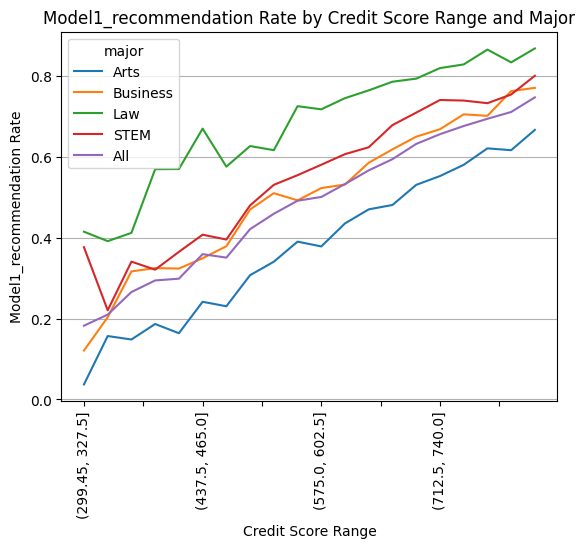

In [39]:
plot_outcome_rate_by_attribute(loandata, 'credit_score', 'model1_recommendation', 'major')

### Problem 2

Use the `plot_outcome_rate_by_attribute` function to graph different properties of the data.  Generate a graph that shows disparaties in loan outcomes based on a protected characteristic (code in the first box below), and describe your interpretation of the graph (text in the second box below).  

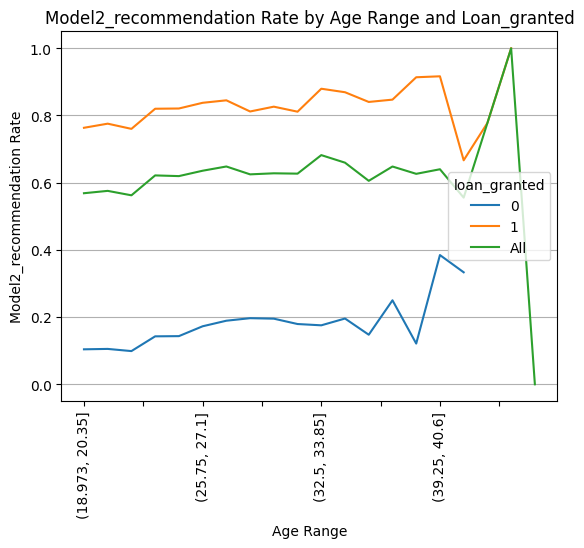

In [40]:
# use this box to write your code to generate graphs of different properties
plot_outcome_rate_by_attribute(loandata, 'age', 'model2_recommendation', 'loan_granted')

This plot shows how Model 2's loan recommendation rate changes across age ranges, separated by whether loans were historically granted or denied. The orange line remains consistently high (around 0.8-0.9), indicating that applicants who were previously approved are also recommended by the model across most ages. The blue line stays much lower (around 0.1-0.3), showing that applicants who were historically denied continue to receive low recommendation rates. The green line reflects the overall trend, falling between the other two lines. A clear trend is that the overall recommendation rate increases gradually with age, suggesting that younger applicants are less likely to be recommended compared to older applicants. This age-dependent slope raises fairness concerns as age is a legally protected characteristic in lending. At the far right of the graph, the sharp spike upward followed by a sudden drop likely reflects sparse data in the oldest age bins. Overall, the plot indicates that Model 2 largely mirrors historical loan decisions, granting more approvals to those already approved in the past, but also reinforcing an age-related disparity. Younger applicants are systematically disadvantaged, which may pose risks of disparate impact and potential violations of fair lending laws.

## Quantitative Fairness Metrics

There are many different measures of fairness, and attempts to capture desired fairness properties in mathematical definition.

We will consider three statistical definitions related to fairness that are described in [Chapter 3: Classification](https://fairmlbook.org/classification.html) of the [Fair ML Book](https://fairmlbook.org).

## Disparate Impact

The readings chapter from the FairML book introduces several different metrics that could be used to assess fairness.

The first one, _independence_, also known as _demographic parity_, is a statistical test on the outcomes.


Given a dataset, we can compute demographic parity from this confusion matrix:

| Output | Minority Class | Majority Class |
| ------- | --------------| --------------|
| Negative Outcome (Loan Rejected) | $a$ | $b$ |
| Positive Outcome (Loan Accepted) | $c$ | $d$ |

If the outcome is independent of the variable used to separate the classes, then the ratio of the acceptance rates should be close to 1. We can compute this ratio as

$$ \frac{c/(a+c)}{d/(d+b)} $$

If the positive outcome (in this case, the loan application being accepted) is less likely for the minority class, then the value of the ratio will be less than 1.


### Problem 3

Define a function `disparate_impact` that measures the independence of an outcome variable given two population subsets. It should take as input two data frames, the first representing the `majority` class and the second representing the `minority` class, the name of the outcome features (e.g., `approved`), and the favorable outcome value. It should return the ratio of the favorable outcome rate for the minority group to the favorable outcome rate for the majority group.

We have provided some test code in the cell below for trying your code on the loan data.

In [41]:
def disparate_impact(majority, minority, outcome, favorable=1):
  # fill in your code here\
  majority_rate = (majority[outcome] == favorable).mean()
  minority_rate = (minority[outcome] == favorable).mean()

  if majority_rate == 0:
    return None
  ratio = minority_rate / majority_rate

  return ratio

In [42]:
 # Here is some code for testing your disparate_impact function
minority = loandata[loandata['race'] == "Black"] # select all records where race is Black
majority = loandata[loandata['race'] == "White"] # select all records where race is White
di = disparate_impact(majority, minority, outcome='loan_granted')
print(f"Granted: Disparate Impact (B/W): {di:.3f}")

di = disparate_impact(majority, minority, outcome='model1_recommendation')
print(f"Model1: Disparate Impact (B/W): {di:.3f}")

di = disparate_impact(majority, minority, outcome='model2_recommendation')
print(f"Model2: Disparate Impact (B/W): {di:.3f}")

minority = loandata[loandata['race'] == "Asian"]
majority = loandata[loandata['race'] == "White"]
di = disparate_impact(majority, minority, outcome='loan_granted')
print(f"Disparate Impact (A/W): {di:.3f}")
di = disparate_impact(majority, minority, outcome='model1_recommendation')
print(f"Model 1 Disparate Impact (A/W): {di:.3f}")
di = disparate_impact(majority, minority, outcome='model2_recommendation')
print(f"Model 2 Disparate Impact (A/W): {di:.3f}")

minority = loandata[loandata['age'] < 35]
majority = loandata[loandata['age'] >= 35]
di = disparate_impact(majority, minority, outcome='loan_granted')
print(f"Disparate Impact (<35/35+): {di:.3f}")

minority = loandata[loandata['race'] == "Black"]['race'].count()
print(f"Total # of Black applicants: {loandata[loandata['race'] == 'Black']['race'].count()}")

minority = loandata[loandata['race'] == "Asian"]['race'].count()
print(f"Total # of Asian applicants: {loandata[loandata['race'] == 'Asian']['race'].count()}")

majority = loandata[loandata['race'] == "White"]['race'].count()
print(f"Total # of White applicants: {loandata[loandata['race'] == 'White']['race'].count()}")


Granted: Disparate Impact (B/W): 0.586
Model1: Disparate Impact (B/W): 0.755
Model2: Disparate Impact (B/W): 0.818
Disparate Impact (A/W): 1.075
Model 1 Disparate Impact (A/W): 1.150
Model 2 Disparate Impact (A/W): 1.041
Disparate Impact (<35/35+): 1.024
Total # of Black applicants: 6778
Total # of Asian applicants: 4209
Total # of White applicants: 32367


### Problem 4

As a team, write 2-3 paragrahs (aprox. 250 words) about what your tests with the `disparate_impact` function revealed about the data, including both the historical decisions and model's predictions. Without conducting a detailed legal analysis, what potential issues do you see that relate to both the potential for discrimination and for broader conceptions of fairness or statistical accuracy?

Our results reveal that historical lending decisions reflect a fairness issue, with an explicit disparate impact between Black and White applicants (0.586 << 0.8). This means that Black applicants were approved at only 58.6% of the rate of White applicants. Model 1 (0.755) comes closer to reproducing this historical disparity than Model 2 (0.818), but both still overestimate approval rates for Black applicants, making them appear overly optimistic compared to reality. In contrast, both models perform well with respect to Asian and White applicants. The historical disparate impact ratio for Asians was 1.075, showing that Asian applicants were slightly more favored than White applicants, and both models reproduced this outcome. Thus, Asian applicants were not disadvantaged as a minority group, whereas Black applicants clearly were, and the models did not adequately capture that disadvantage.

Both models and the actual historical approvals of loans granted are significantly lower than the proportion of White applicants' predicted and actual approval rate. Without a reasonable explanation of the disparity, this indicates evidence of discrimination against Black applicants. While the difference between actual granted loans and the models' predictions appears substantial, closer inspection shows the gap is less pronounced, especially for Black applicants. Based on Model 1's ratio (0.755), about 4094 Black applicants should have been approved, compared to the actual 3972—a difference of only about 3%. This suggests that Model 1's predictions are roughly consistent with historical outcomes, yet both history and the models still reflect the broader pattern of disadvantage against Black applicants.

## Error Rate Parity

The _error rate parity_ fairness notion is based on equalizing prediction error rates across classes. For the true positive rate, this reflects the probability of getting the positive prediction for an input where the true value is positive.

With ground truth data, we can compute the error rates of a classifiers. The (simulated) historical data provides this for the granted loans.

The `compute_error_rates` function defined below computes the true positive rate and false positive rate for an input data frame. We've provided the code for this, but you should be able to understand it.

In [43]:
def compute_error_rates(df, prediction='model1_recommendation',
                        verbose=False):
  """
  Return the true positive rate and false positive rate
  for the input prediction, where 'good_loan' gives the
  true value. We defined a "positive" as a loan that was
  recommended (by the prediction), and it is a "true positive"
  if 'good_loan' == 1 and a "false positive" if 'good_loan' == 0.

  df is a data frame of loan applications
  """
  # We can only consider the granted loans, since we
  # don't know if ungranted loans would have defaulted.
  granted_loans = df[df['loan_granted'] == 1]
  nloans = len(granted_loans)

  # These define Boolean masks for the application indexes where
  # the prediction recommends the loan, and where the loan was good.
  recommended = (granted_loans[prediction] == 1)
  goods = (granted_loans['good_loan'] == 1)

  num_positives = len(granted_loans.loc[goods])
  num_negatives = len(granted_loans.loc[~goods])

  true_positives  = len(granted_loans.loc[recommended & goods])   # recommended and did not default
  false_positives = len(granted_loans.loc[recommended & ~goods])  # recommended but defaulted

  true_negatives  = len(granted_loans.loc[~recommended & ~goods]) # not recommended and defaulted
  false_negatives = len(granted_loans.loc[~recommended & goods])  # not recommended but did not default

  assert true_positives + false_negatives == num_positives
  assert false_positives + true_negatives == num_negatives

  tpr = true_positives / num_positives if num_positives > 0 else 0
  fpr = false_positives / num_negatives if num_negatives > 0 else 0

  if verbose:
    print(f"Group size: {len(df)}")
    print(f"Granted loans: { len(granted_loans)}, "
          f"Recommended approvals: { recommended.astype(int).sum() }, "
          f"Defaults: { num_negatives } ({ (num_negatives / nloans):.3f}))")
    print(f"Bad Approvals (False Positives): { false_positives } of { num_negatives } bad loans")
    print(f"Bad Rejections (False Negatives): { false_negatives } of { num_positives } good loans")

  return tpr, fpr

Here's an example using it to see the error rates for a subpopulation:

In [44]:
tpr, fpr = compute_error_rates(loandata, verbose=True)
print(f"True Positive Rate: {tpr:.3f}, False Positive Rate: {fpr:.3f}")
group = loandata[(loandata['major'] == 'Law')]
tpr, fpr = compute_error_rates(group, verbose=True)
print(f"True Positive Rate: {tpr:.3f}, False Positive Rate: {fpr:.3f}")

Group size: 50000
Granted loans: 35029, Recommended approvals: 27465, Defaults: 2395 (0.068))
Bad Approvals (False Positives): 497 of 2395 bad loans
Bad Rejections (False Negatives): 5666 of 32634 good loans
True Positive Rate: 0.826, False Positive Rate: 0.208
Group size: 5246
Granted loans: 4161, Recommended approvals: 3699, Defaults: 95 (0.023))
Bad Approvals (False Positives): 44 of 95 bad loans
Bad Rejections (False Negatives): 411 of 4066 good loans
True Positive Rate: 0.899, False Positive Rate: 0.463


### Problem 6

Use error rate parity tests to examine the loan data and look for possible evidence of unfairness.

You should use the following code cell to write code to explore the data, and the text cell after that to discuss your analysis and what the implications are for fairness.

You can use the function we defined above, but are encouraged to go beyond this in expanding and automating your analysis.

In [45]:
for model in ['model1_recommendation', 'model2_recommendation']:
    print(f"\nError Rates by race for {model}:")
    for race in ['White', 'Black', 'Asian']:
        group = loandata[loandata['race'] == race]
        tpr, fpr = compute_error_rates(group, prediction=model, verbose=False)
        print(f"{race}: TPR={tpr:.3f}, FPR={fpr:.3f}")

for model in ['model1_recommendation', 'model2_recommendation']:
    print(f"\nError Rates by age for {model}:")
    under35 = loandata[loandata['age'] < 35]
    over35  = loandata[loandata['age'] >= 35]
    tpr_u, fpr_u = compute_error_rates(under35, prediction=model, verbose=False)
    tpr_o, fpr_o = compute_error_rates(over35,  prediction=model, verbose=False)
    print(f"<35:  TPR={tpr_u:.3f}, FPR={fpr_u:.3f}")
    print(f"35+:  TPR={tpr_o:.3f}, FPR={fpr_o:.3f}")


Error Rates by race for model1_recommendation:
White: TPR=0.822, FPR=0.194
Black: TPR=0.794, FPR=0.319
Asian: TPR=0.889, FPR=0.262

Error Rates by race for model2_recommendation:
White: TPR=0.851, FPR=0.007
Black: TPR=0.888, FPR=0.014
Asian: TPR=0.840, FPR=0.011

Error Rates by age for model1_recommendation:
<35:  TPR=0.826, FPR=0.207
35+:  TPR=0.872, FPR=0.212

Error Rates by age for model2_recommendation:
<35:  TPR=0.855, FPR=0.008
35+:  TPR=0.924, FPR=0.000


As a team, write a one-paragraph explanation of your analysis and your interpretation of the results. Is the model unfair from the perspective of error rate parity? If so, in what ways?

Our analysis of error rate parity shows evidence of unfairness in the models. In Model 1, the True Positive Rate (TPR) is higher for Asian applicants (0.889) than for Black applicants (0.794), while the False Positive Rate (FPR) varies widely (0.194 for White vs. 0.319 for Black). This indicates inconsistent error behavior across racial groups. Model 2 reduces these disparities, with both TPR and FPR more consistent across races, although Asian applicants have a slightly lower TPR (0.840) compared to Model 1. For age groups, Model 1 again shows imbalance. Applicants under 35 have a TPR of 0.826 and an FPR of 0.207, compared with 0.872 and 0.212 for applicants 35 and older. This means younger applicants face more false rejections of good loans and a higher rate of false approvals. Model 2 largely eliminates these disparities, producing very similar error rates across age categories. From the perspective of error rate parity, Model 1 fails to meet fairness standards across both race and age, while Model 2 achieves stronger parity and thus produces fairer outcomes.

#**Target for Week 1**

This is where we expect you to get before the class on September 19. It is fine if you want to go further, of course. In class on September 19 we will answer any questions you have about the project up to here, talk some about the rest of the project, and give you some time to continue working in your team for the next part.

# Training Models



For the rest of this project, you will get some experience training and testing models and to attempt to train a model that both performs well (according to your loss function), that satisfies fairness goals, and that does not violate anti-discrimination laws. (Note that it may not be possible to satisfy all three of these!)


We will use the sklearn library, which supports several different types of models.

Execute the cell below to import some models from sklearn:

In [46]:
# Imports from sklearn for building and evaluating models.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

To train a model, we need to select the data to train on (including the features to use in training), select the model architecture, and run an algorithm that trains the model.

One of the things Earnest LLC is described as doing is training a model (the "SLO model", for  Student Loan Origination (new loans)) on decisions made by an earlier model (the "SLR model",for Student Loan Refinance).

It is not clear from the settlement how the SLR model was developed, but we are going to simulate what is commonly done which is to train a model on available historical data. As you should understand from the readings and class discussions (and your explorations in this project), training models on historical data poses many pitfalls.


## Preparing the Data

Before we can use the available data for training, some preparation is useful to get it into a form that will be better for training.

For this data, we change the categorical fields (e.g., `major` that can be one of a handful of different values in our data set) to a set of binary fields for each category (where the value will be `0` for each field, other than the one that corresponds to the actual categorical value for which it will be `1`).  Since there is no specific ordering of the values and a mapping to numbers would not make sense, converting the data this way should result in better results.

The code below prepares the data in this format. It isn't important to understand this code.

In [47]:
def prepare_data(df, training_features, prediction, verbose=False):
    """
    Prepare data for training by handling categorical features and
    separating features (X) and target (y).
    """
    df = df.copy()
    tf = training_features.copy() # copy to avoid modifying input
    prepared_features = []

    all_cols = list(df.columns)
    numeric_cols = list(df.select_dtypes(include="number").columns)
    categorical_cols = list(df.select_dtypes(exclude="number").columns)

    # One-hot encode all categorical features in training_features
    for c in categorical_cols:
        if c in training_features:
            tf.remove(c)
            cats = pd.Index(sorted(df[c].astype(str).unique()))
            if len(cats) > 2:
              for v in cats:
                  cat_feature = c + "_" + str(v)
                  prepared_features.append(cat_feature)
                  df[cat_feature] = (df[c] == v).astype(int)
            else:
              df[c] = (df[c] != cats[0]).astype(int)

    # Add remaining training features (numeric) to prepared_features
    prepared_features.extend([f for f in tf if f in numeric_cols])

    # Ensure only selected and prepared training features are in X
    X = df[prepared_features]
    y = df[prediction]

    if verbose: print(f"X: {list(X.columns)}")
    if verbose: print(f"y: {y.name} ({y.dtype})")
    assert len(X) == len(y), "Feature and target lengths do not match."
    return X, y

## Training Inference Models

The function defined below takes the training data, a list of the fields to use in training, and the field to predict, and returns a model trained on the data.

Here, we train a logistic regression model (CS students with ML experience may be able to explain what that is and write code to use different model types, but it is sufficient now to just understand that it is a simple model we can train to make binary predictions):

In [48]:
def train_model(training_data, training_fields,
                prediction, verbose=True):
  """
  Trains a model on the training_data using the training_fields
  to predict the prediction output.
  """
  X_train, y_train = prepare_data(training_data,
                                  training_fields,
                                  prediction)

  # We use balanced class_weight here, but this is something
  # you could try changing in the last problem.
  # (Suggestion: ask a poe AI to explain class_weight parameter)
  model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
  model.fit(X_train, y_train)
  return model

That's all the code we need to train a model! The `model = LogisticRegression(...)` line creates the untrained model and sets some training hyperparameters, and the `model.fit` call performs the training to find parameters that fit the outputs in `y_train`.

Before using this, we also define some functions for testing a model:

In [49]:
def make_predictions(model, X_test, y_test,
                     verbose=True):
    """
    Evaluate the model on the test set, making the outcome predictions
    with the positive (1) value matching the target_rate.
    """
    assert type(X_test) == pd.DataFrame, "X_test must be a DataFrame: " + str(type(X_test))
    assert type(y_test) == pd.Series, "y_test must be a Series: " + str(type(y_test))

    y_scores = model.predict_proba(X_test)[:, 1]

    # pick threshold to maximize F1
    ths = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_test, y_scores >= t) for t in ths]
    t_best = ths[int(np.argmax(f1s))]
    if verbose: print(f"Selected threshold: {t_best}")

    y_pred = (y_scores >= t_best).astype(int)
    return y_pred

def test_model(model, testing_data, fields,
               prediction, verbose=True):
    """
    Evaluate the model on the test set.

    Returns the f1score for the model, but with verbose prints out other statistics.
    """
    X_test, y_test = prepare_data(testing_data, fields, prediction)
    y_pred = make_predictions(model, X_test, y_test, verbose)
    f1score = f1_score(y_test, y_pred)

    if verbose:
      print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f} "
            f"AUC: {roc_auc_score(y_test, y_pred):.3f} "
            f"F1: {f1score:.3f}")

    return f1score

Now we have all the code we need to train and test models. Here's an example:

In [50]:
training = load_data('loan-training.csv') # same data as before
testing = load_data('loan-testing.csv')

Loaded loan-training.csv: 50000 rows, 18 columns
Loaded loan-testing.csv: 20000 rows, 16 columns


### Problem 7

Try training and testing some models on the provided data.

We've provided some initial code that shows how to use the functions to do this (and for thie problem you are not expected to modify the function definitions above, but are encouraged to do so if you want). You should modify this code the try changing the features used in training and what is predicted. (Note that below we define a function that can be used to run an experiment like this, but before using that to do more systematic experiments, just try some manual ones with this code to understand all the steps in training and testing a model.)

In [51]:
# We've provided some starting example code here.
# You should change this code to experiment with the impact of different
# features on the model performance.
tf1 = [ 'income', 'credit_score', 'dti',
        'program_level', 'major',
        'cohort_default_rate', 'loan_amount' ]

prediction = 'loan_granted' # train to match historical decisions (not outcomes)
model = train_model(training, tf1, prediction)
test_model(model, testing, tf1, prediction)

Selected threshold: 0.89
Accuracy: 0.922 AUC: 0.922 F1: 0.928


0.9277777777777778

In [52]:
#Filtering to rows where loan_granted is equal to 1 and good_loan is not NaN (an empty value)
training_granted = training[training['loan_granted'] == 1].dropna(subset=['good_loan'])
testing_granted = testing[testing['loan_granted'] == 1].dropna(subset=['good_loan'])

#Choosing the input features (evidence we give to the model)
tf2 = ['income', 'credit_score', 'dti','loan_amount']

#Choosing the prediction target (the outcome we want the model to learn)
new_prediction = 'good_loan'

#Training and testing the model
new_model = train_model(training_granted, tf2, new_prediction)
test_model(new_model, testing_granted, tf2, new_prediction)

Selected threshold: 0.14
Accuracy: 0.954 AUC: 0.678 F1: 0.976


0.9761733544273455

## Evaluating Fairness

The code we provided in `test_model` produces some accuracy-based statistics for a model, but does not consider any fairness criteria. In the next problem, you will incorporate some statistical fairness tests in your model evaluation.


### Problem 8

Define a `test_model_fairness` function (starting from the template below which is the same code as for `test_model` above) that incorporates fairness tests into the evaluation. You can (and should) use functions you defined earlier, but should think about what tests to perform.

In [53]:
## Modify the code in this cell to incorporate fairness tests.

def test_model_fairness(model, testing_data, fields,
                        prediction, verbose=True):
    """
    Evaluate the model on the test set, making the outcome predictions
    with the positive (1) value.

    Returns the f1score for the model, but with verbose prints out other statistics.
    """
    X_test, y_test = prepare_data(testing_data, fields, prediction)
    y_pred = make_predictions(model, X_test, y_test, verbose)
    f1score = f1_score(y_test, y_pred)

    if verbose:
      print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f} "
            f"AUC: {roc_auc_score(y_test, y_pred):.3f} "
            f"F1: {f1score:.3f}")

    print("\nFairness Tests")

    #Attaching the predictions back to the same dataset used here
    testing_with_preds = testing_data.copy()
    testing_with_preds['model_pred'] = y_pred

    #Fairness Test 1: Checking for Disparate Impact (Black vs White applicants)
    black = testing_with_preds[testing_with_preds['race'] == "Black"]
    white = testing_with_preds[testing_with_preds['race'] == "White"]
    asian = testing_with_preds[testing_with_preds['race'] == "Asian"]
    di_b_w = disparate_impact(white, black, outcome="model_pred")
    di_a_w = disparate_impact(white, asian, outcome="model_pred")
    print(f"Disparate Impact (B/W): {di_b_w:.3f}")
    print(f"Disparate Impact (A/W): {di_a_w:.3f}")

    #Fairness Test 2: Checking for Error Rate Parity (True Positive Rate and False Positive Rate)
    tpr_w, fpr_w = compute_error_rates(white, prediction="model_pred", verbose=False)
    tpr_b, fpr_b = compute_error_rates(black, prediction="model_pred", verbose=False)
    tpr_a, fpr_a = compute_error_rates(asian, prediction="model_pred", verbose=False)

    print(f"White Applicant Error Rates: TPR={tpr_w:.3f}, FPR={fpr_w:.3f}")
    print(f"Black Applicant Error Rates: TPR={tpr_b:.3f}, FPR={fpr_b:.3f}")
    print(f"Asian Applicant Error Rates: TPR={tpr_a:.3f}, FPR={fpr_a:.3f}")

    return f1score

In [54]:
# Here's an example of using your function.
# You should change this to try variations, and
# your function should produce output that includes
# fairness criteria.

test_model_fairness(model, testing, tf1, prediction)

Selected threshold: 0.89
Accuracy: 0.922 AUC: 0.922 F1: 0.928

Fairness Tests
Disparate Impact (B/W): 0.668
Disparate Impact (A/W): 1.085
White Applicant Error Rates: TPR=0.932, FPR=0.643
Black Applicant Error Rates: TPR=0.949, FPR=0.750
Asian Applicant Error Rates: TPR=0.931, FPR=0.638


0.9277777777777778

## Improving Models

For the final part of this assignment, your goal is to produce a better method for making loan recommendations, that considers business, fairness, and legal aspects.

### Problem 9

Based on your work above to measure the fairness of models, develop a better model. Be explicit about what you are seeking to maximize, both in terms of fairness and predictive power. Keep in mind the side constraints imposed by discrimination law.

(This problem is quite open ended, and we'll talk more in class on Sept 19 about what we expect at a minimum for this, and ways more ambitious teams could go beyond that.)

In [55]:
# Use this, and additional cells as useful for your work
# on this problem.

fair_features = ["income", "credit_score", "dti", "loan_amount", "age"]
fair_prediction = "good_loan"
fair_model = train_model(training_granted, fair_features, fair_prediction)
test_model_fairness(fair_model, testing_granted, fair_features, fair_prediction)


Selected threshold: 0.12
Accuracy: 0.955 AUC: 0.666 F1: 0.976

Fairness Tests
Disparate Impact (B/W): 1.017
Disparate Impact (A/W): 0.985
White Applicant Error Rates: TPR=0.995, FPR=0.673
Black Applicant Error Rates: TPR=0.996, FPR=0.667
Asian Applicant Error Rates: TPR=0.992, FPR=0.596


0.9764103545624192

### Problem 10

As a team, write a 4-5 paragraph summary of your approach. Include discussion of the fairness conditions you sought to maximize, the effect of discrimination law on your approach, and your assessment of the results. In the end, is  the model still unfair from the perspective of error rate parity? If so, in what ways?

For Group Project #1, there will be no individual reflection papers.

In developing our final model, our main goal was to balance accuracy with fairness. The earlier models (Model 1 and Model 2) were reasonably accurate but replicated biased historical patterns, particularly disadvantaging younger and Black applicants. To address this, we trained a new model to predict annual repayment outcomes (“good_loan”) instead of reproducing past approvals, and we limited the features to financial indicators such as income, credit score, debt-to-income ratio, and loan amount.

We also tested two different feature sets. The first excluded age and relied only on financial indicators, producing strong results compared with earlier models. The second included age, but the overall performance did not change significantly. The only differences were a slight increase in the True Positive Rate (TPR) for Asian applicants (+0.002) and a minor decrease for Black applicants (-0.001), suggesting that age added little predictive value while raising fairness concerns.

The new model performed strongly, achieving higher accuracy and F1 scores than Model 1 and Model 2 while producing more balanced outcomes across groups. Disparate impact ratios moved closer to 1, and error rates across racial groups became more consistent. These results indicate that the model not only improves predictive performance but also better aligns with fairness principles and anti-discrimination standards in lending.

Nevertheless, the model is not perfect. Some disparities remain, particularly in False Positive Rates (FPR), which remain relatively high. Whether the model is considered fair ultimately depends on the fairness standard applied: those emphasizing high TPR and balanced disparate impact may judge it acceptable, whereas those emphasizing low FPR may still view it as problematic. Overall, however, the model represents a significant step toward reducing unfairness compared with earlier models.

# End of Project 1

To submit your project, select "File | Print" to generate a PDF file. Check that it includes your answers including outputs from executing cells. In Canvas, each team will submit **one PDF file** that reflects your work as a group to the **Canvas Group Project 1 Assignment**.